In [3]:
def plot_images(image_list, title_list, grid='off', file_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10))
    
    if len(image_list) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)
    
    if file_name is not None:
        fig.savefig(results_directory + file_name)
        print('Image Plot Saved:', results_directory + file_name)

In [4]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [5]:
image_directory = 'images\\'

img1 = cv2.imread(image_directory + '1.png')
img1 = cv2.resize(img1, (0, 0), fx=1, fy=1)

img2 = cv2.imread(image_directory + '2.png')
img2 = cv2.resize(img2, (0, 0), fx=1, fy=1)

img3 = cv2.imread(image_directory + '3.png')
img3 = cv2.resize(img3, (0, 0), fx=1, fy=1)

img4 = cv2.imread(image_directory + '4.png')
img4 = cv2.resize(img4, (0, 0), fx=1, fy=1)

img5 = cv2.imread(image_directory + '5.png')
img5 = cv2.resize(img5, (0, 0), fx=1, fy=1)

In [6]:
images = [img1, img2, img3, img4, img5]

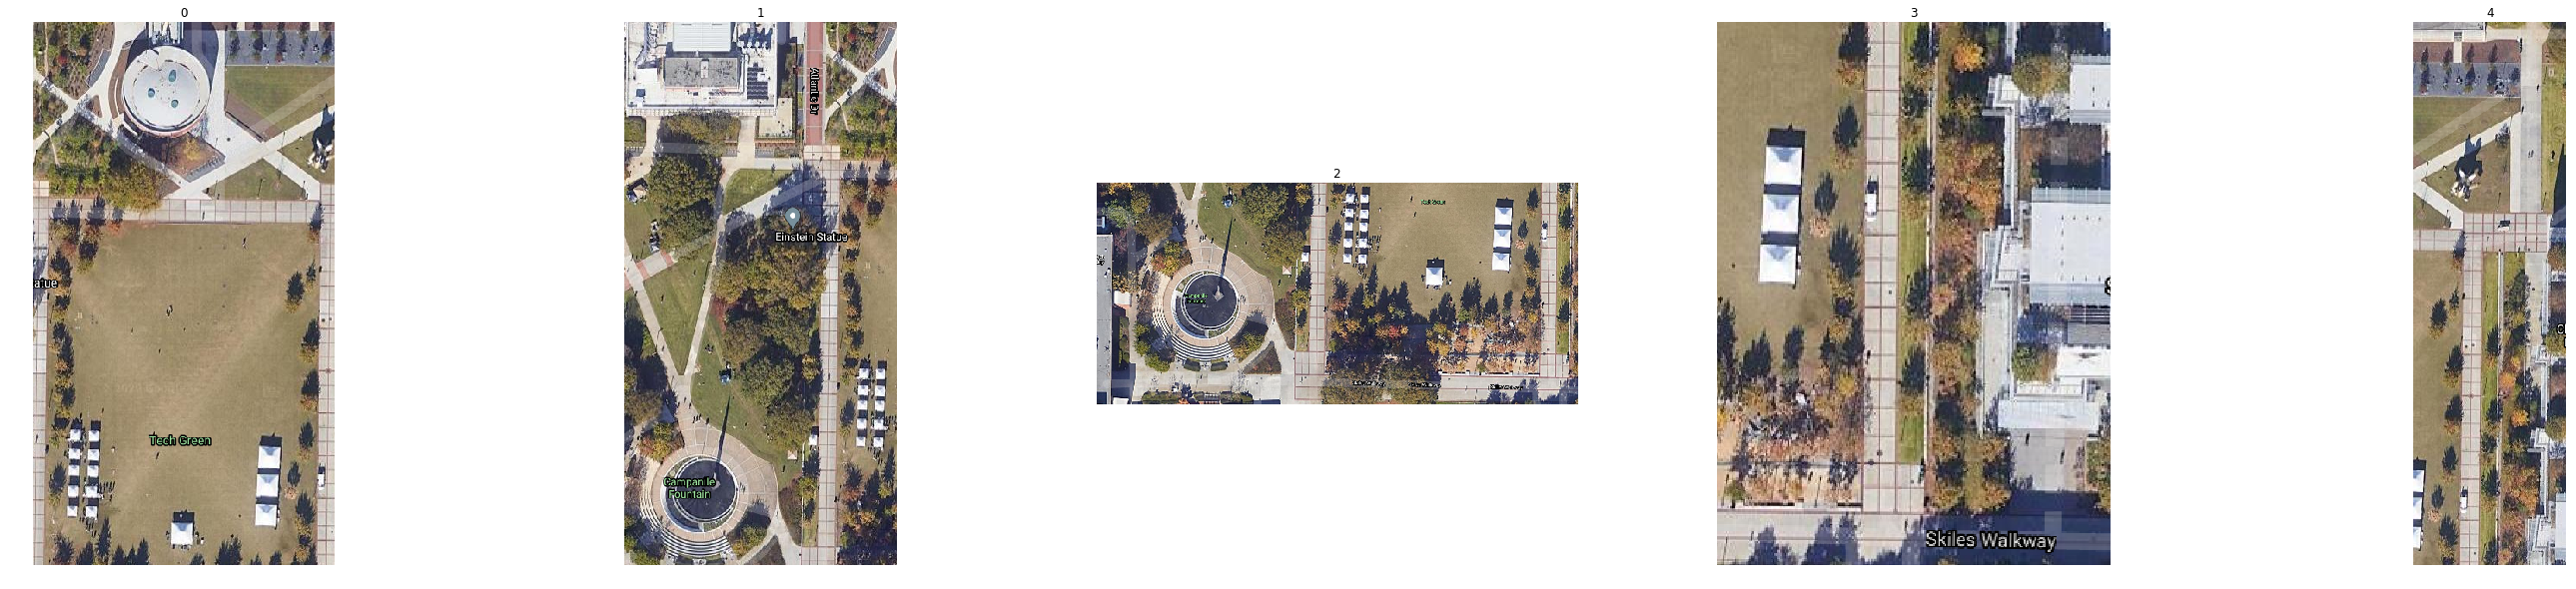

In [7]:
image_list = images
title_list = ['0', '1', '2', '3', '4']
plot_images(image_list, title_list)

## Keypoint Detector

https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83

https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html#:~:text=ORB%20is%20basically%20a%20fusion,pyramid%20to%20produce%20multiscale%2Dfeatures.

In [8]:
IMAGE_ID = 0
NUM_CLUSTERS = 3

original_img = images[IMAGE_ID]
HEIGHT, WIDTH, CHANNELS = original_img.shape

### Some kind of clustering - KMeans / CNN

In [9]:
from scipy import stats

def get_mode(img):
    unq, count = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
    return unq[count.argmax()]

def modeBlur(img, kernel_size):
    mode_img = np.zeros((img.shape))
    
    for i in range(0, int(img.shape[0]/kernel_size)):
        for j in range(0, int(img.shape[1]/kernel_size)):
            rows = slice(i*kernel_size, (i+1)*kernel_size)
            cols = slice(j*kernel_size, (j+1)*kernel_size)

            mode_img[rows, cols] = get_mode(img[rows, cols])
    
    return mode_img

In [10]:
def clustering(img):
    X = np.reshape(img, [-1, CHANNELS]).astype(np.float32)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X)
    
    clustered_img = np.reshape(kmeans.cluster_centers_[kmeans.labels_], (HEIGHT, WIDTH, CHANNELS)).astype(np.uint8)
    
    smooth_img = cv2.medianBlur(clustered_img, 5).astype(np.uint8)
    # smooth_img = modeBlur(clustered_img, 4).astype(np.uint8)

    return clustered_img, smooth_img

## BGR - Clustered

In [11]:
clustered_img, smooth_img = clustering(original_img)

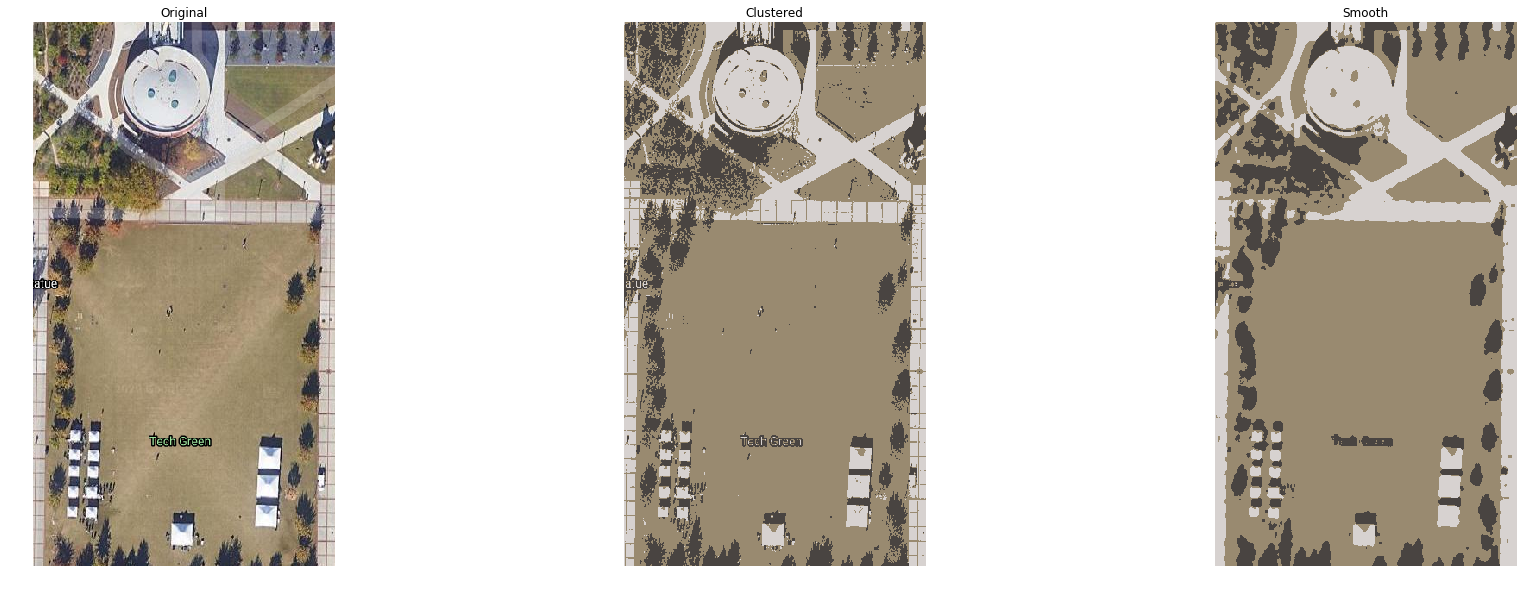

In [12]:
image_list = [original_img, clustered_img, smooth_img]
title_list = ['Original', 'Clustered', 'Smooth']
plot_images(image_list, title_list)

## HSV - Clustered

In [13]:
original_img_hsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

clustered_img_hsv, smooth_img_hsv = clustering(original_img_hsv)

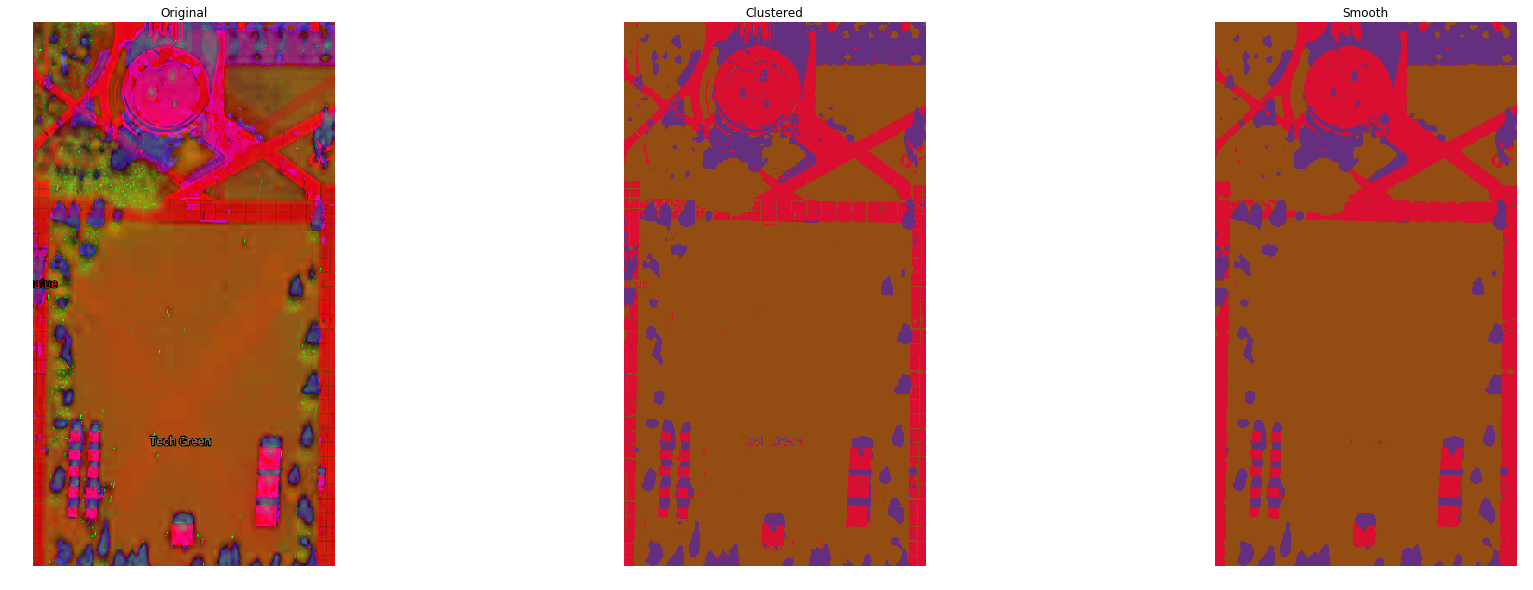

In [14]:
image_list = [original_img_hsv, clustered_img_hsv, smooth_img_hsv]
title_list = ['Original', 'Clustered', 'Smooth']
plot_images(image_list, title_list)

### BGR

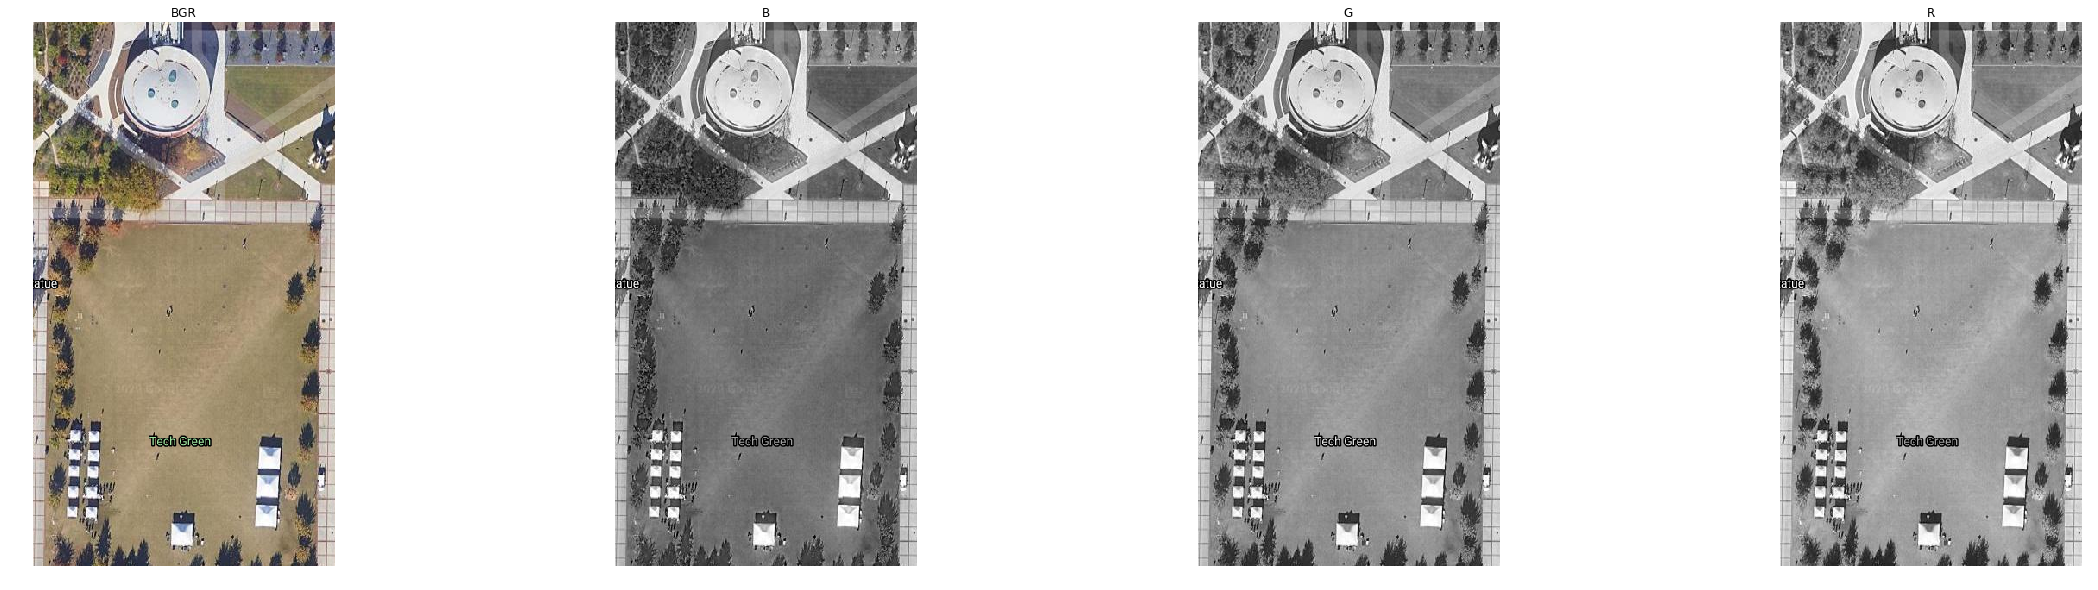

In [16]:
image_list = [original_img, original_img[:, :, 0], original_img[:, :, 1], original_img[:, :, 2]]
title_list = ['BGR', 'B', 'G', 'R']
plot_images(image_list, title_list)

### HSV

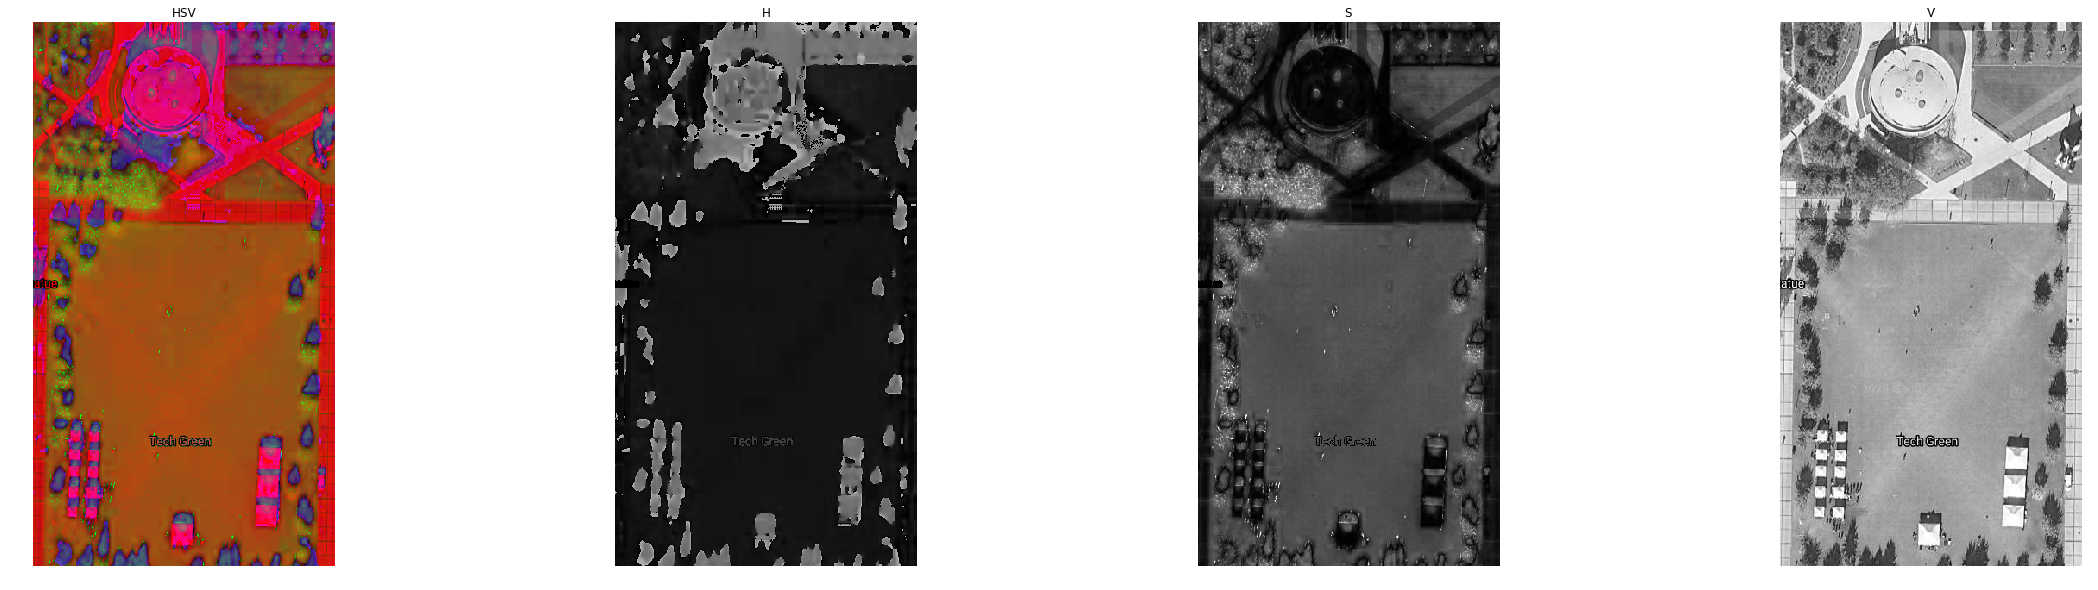

In [17]:
image_list = [original_img_hsv, original_img_hsv[:, :, 0], original_img_hsv[:, :, 1], original_img_hsv[:, :, 2]]
title_list = ['HSV', 'H', 'S', 'V']
plot_images(image_list, title_list)

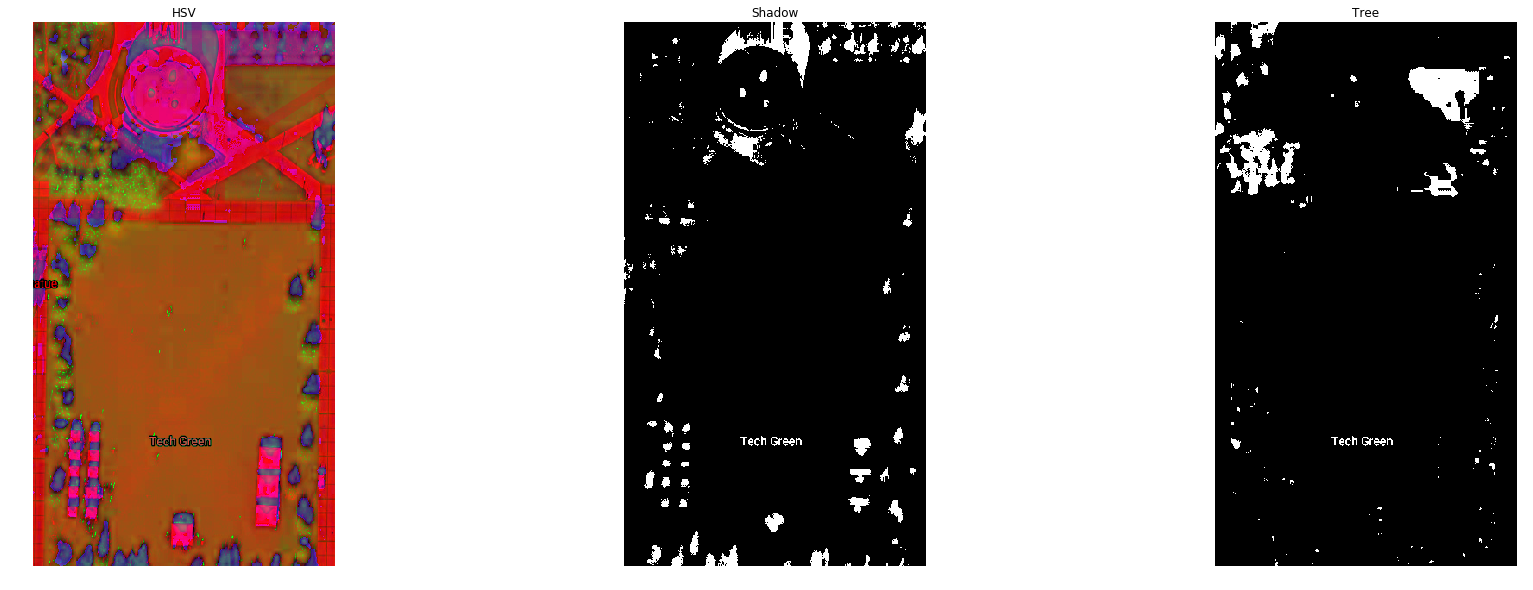

In [30]:
lower_blue_shadow = np.array([50, 50, 50]) #HSV
upper_blue_shadow = np.array([175, 255, 255])
mask = cv2.inRange(original_img_hsv, lower_blue_shadow, upper_blue_shadow)
shadow_img = cv2.bitwise_and(mask, mask)

lower_green_tree = np.array([25, 50, 50]) #HSV
upper_green_tree = np.array([100, 255, 255])
mask = cv2.inRange(original_img_hsv, lower_green_tree, upper_green_tree)
tree_img = cv2.bitwise_and(mask, mask)

image_list = [original_img_hsv, shadow_img, tree_img]
title_list = ['HSV', 'Shadow', 'Tree']
plot_images(image_list, title_list)

(631, 350)


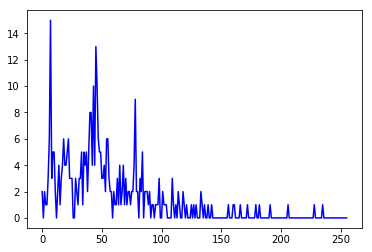

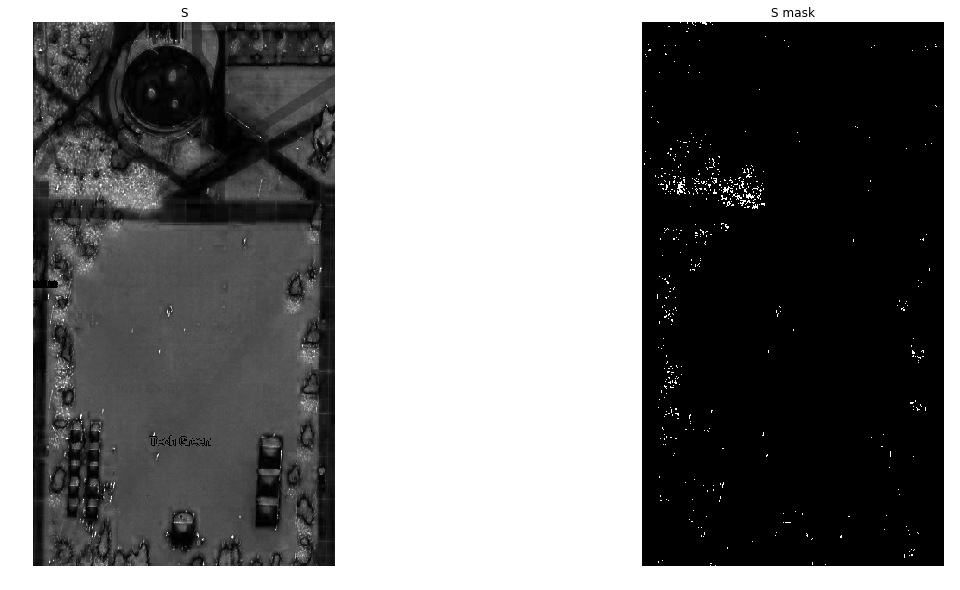

In [37]:
s = cv2.calcHist(original_img_hsv[:, :, 1], [0], None, [256], [0, 256])
plt.plot(s, 'b')


mask = original_img_hsv[:, :, 1] > 150
mask = mask.astype(np.uint8)*255

image_list = [original_img_hsv[:, :, 1], mask]
title_list = ['S', 'S mask']
plot_images(image_list, title_list)

Number of lines: 89
Number of circles: 53


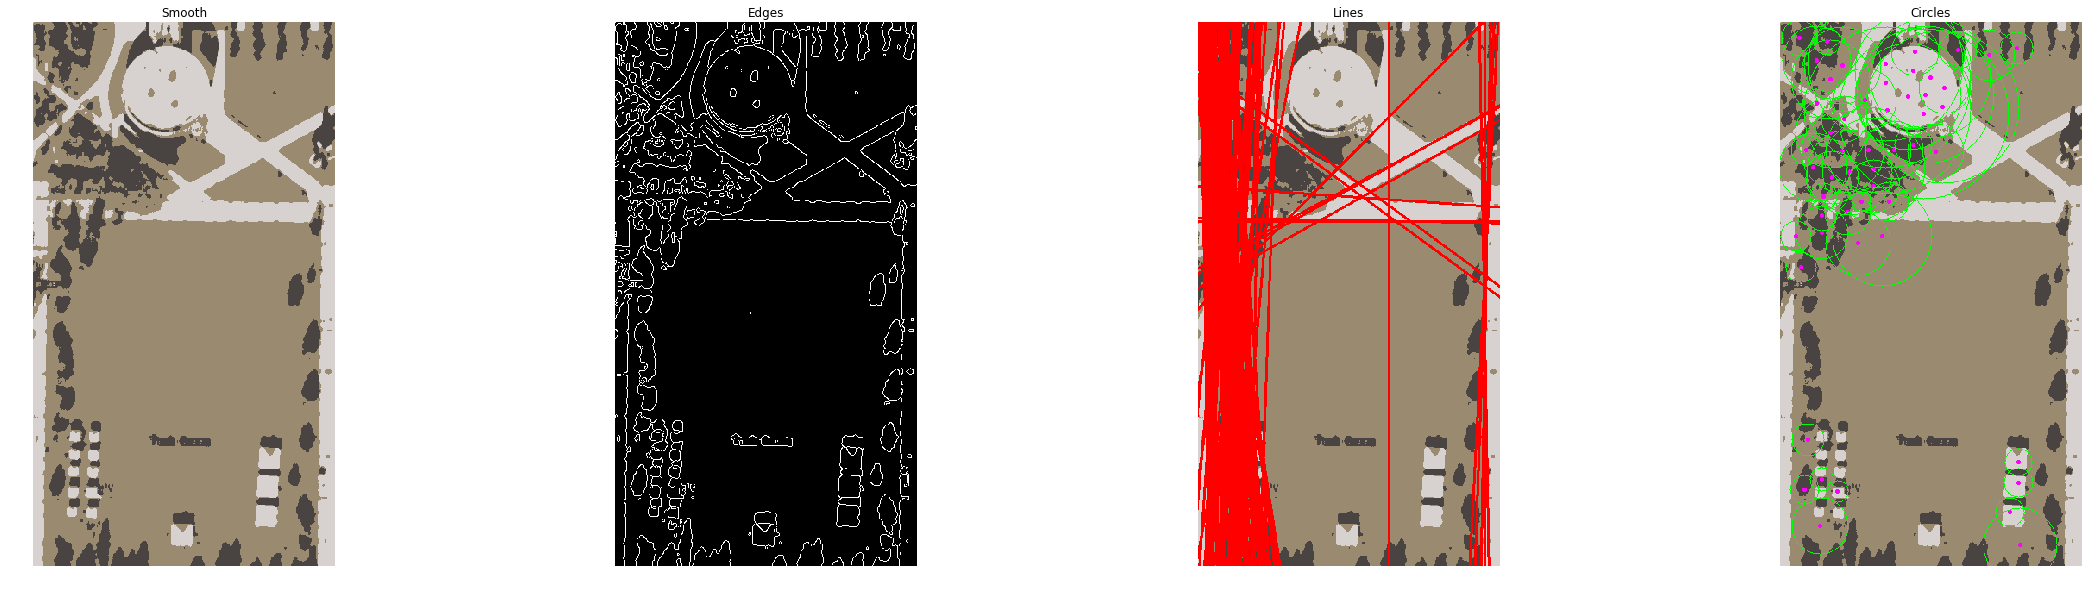

In [72]:
edges = cv2.Canny(cv2.cvtColor(smooth_img, cv2.COLOR_BGR2GRAY), 100, 200)

smooth_img_lines = copy.deepcopy(smooth_img)
smooth_img_circles = copy.deepcopy(smooth_img)

lines = cv2.HoughLines(edges, 1, np.pi/180, 80)
if lines is not None:
    print('Number of lines:', lines.shape[0])
    for line in lines:
        rho = line[0][0]
        theta = line[0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1011*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(smooth_img_lines, (x1,y1), (x2,y2), (0, 0, 255), 2)
    
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=100)
if circles is not None:
    circles = np.uint16(np.around(circles))
    print('Number of circles:', circles.shape[1])

    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        cv2.circle(smooth_img_circles, center, 1, (255, 0, 255), 2)
        radius = circle[2]
        cv2.circle(smooth_img_circles, center, radius, (0, 255, 0), 1)

image_list = [smooth_img, edges, smooth_img_lines, smooth_img_circles]
title_list = ['Smooth', 'Edges', 'Lines', 'Circles']
plot_images(image_list, title_list)

0
0
0


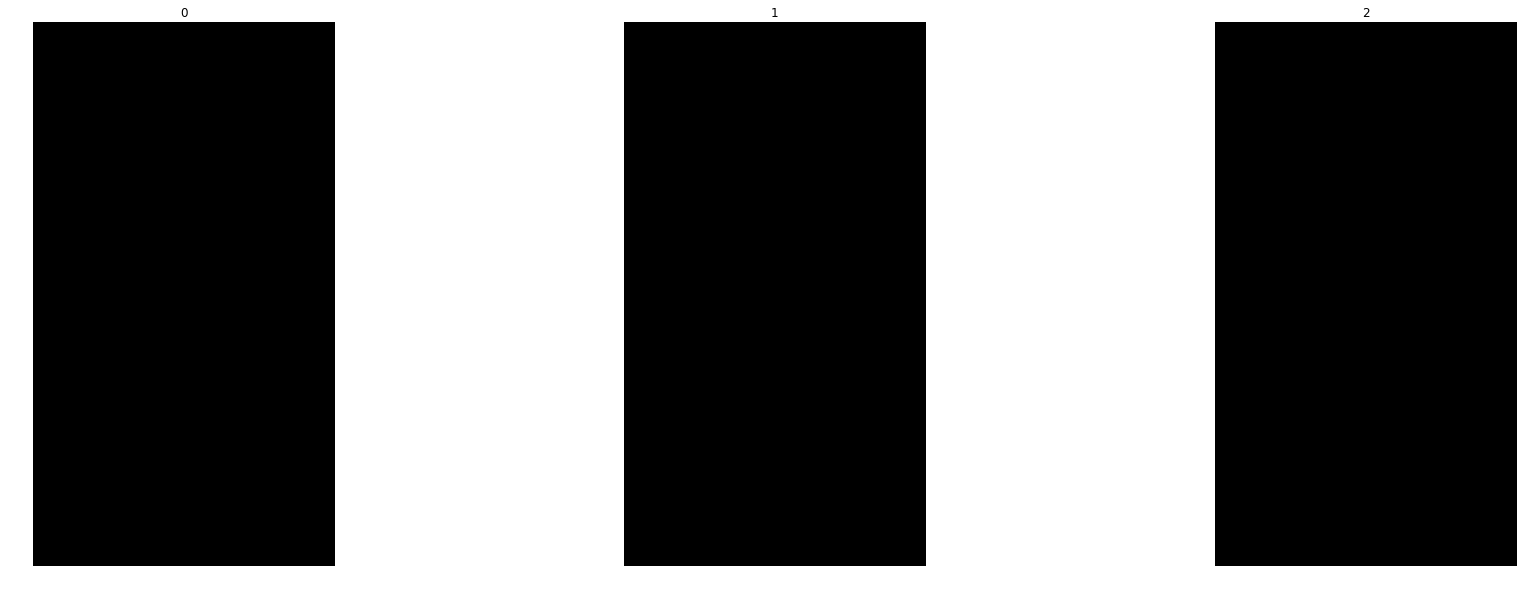

In [71]:
# display each region separately

regions = []
for i in range(0, NUM_CLUSTERS):
    mask = smooth_img == kmeans.cluster_centers_[i]
    mask = mask.astype(np.uint8)
    print(np.sum(mask))
    regions.append(mask[:, :, 0]) # 3 channels are just copies
    
# correct region is white
image_list = regions
title_list = ['0', '1', '2']
plot_images(image_list, title_list)

In [ ]:
# smooth regions

from skimage.morphology import disk

smooth_regions = []
for i in range(0, NUM_CLUSTERS):
    smooth_region = cv2.erode(regions[i], disk(radius=2), iterations=1)
    smooth_regions.append(smooth_region)
    
image_list = smooth_regions
title_list = ['0', '1', '2']
plot_images(image_list, title_list)

In [ ]:
# now put together, since dilate was down and regions shrunk there should be "natural" borders between the regions

colored_regions = []
for i in range(0, NUM_CLUSTERS):
    
    mask = smooth_regions[i] == 255
    colored_region = np.zeros((HEIGHT, WIDTH, 3))
    
    # assign color
    if i == 0:
        color = [255, 0, 0]
    elif i == 1:
        color = [0, 255, 0]
    elif i == 2:
        color = [255, 255, 0]
    elif i == 3:
        color = [0, 0, 255]
    elif i == 4:
        color = [255, 0, 255]
    
    for j in range(0, 3):
        colored_region[mask, j] = color[j]
    
    colored_regions.append(colored_region.astype(np.uint8))

image_list = colored_regions
title_list = ['0', '1', '2']
plot_images(image_list, title_list)

In [47]:
full_stack = np.zeros((HEIGHT, WIDTH, 3))

for i in range(0, NUM_CLUSTERS):
    mask = colored_regions[i] != 0 # != 0 is color
    full_stack[mask] = colored_regions[i][mask]
    
full_stack = full_stack.astype(np.uint8)

image_list = [images[ID], full_stack]
title_list = ['Original', 'Color Segmented']
plot_images(image_list, title_list)

NameError: name 'colored_regions' is not defined